In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from lib import app
from lib.extract import get_frames
from lib.utils import load_points, save_points

plt.style.use(os.path.join('..', 'configs', 'mplstyle.yaml'))

%load_ext autoreload
%autoreload 2

DATA_ROOT_DIR = os.path.join('..', 'data')

# Intrinsic Calibration
## 0. Define Params

In [2]:
YEAR = 2022

# checkerboard info
INTRINSIC_BOARD_SHAPE = (9, 6) # (horizontal, vertical) num of inner corners of checkerboard pattern
INTRINSIC_SQUARE_LEN = 0.031    # length of one side of black/white chessboard square in metres

# automatically defined params - do not modify
INTRINSIC_DATA_DIR = os.path.join(DATA_ROOT_DIR, "intrinsic_calib", str(YEAR))

## 1. Extract frames
You must first define the video you wish to use for calibration. Eg. for 2019, you can define video_fname to be '1.mp4' or '2.mp4'.
GUI usage:
- `.` - Next frame
- `,` - Previous frame
- `s` - Save current frame
- `q` - Quit

In [29]:
video_fname = '1.mp4'

intrinsic_video_path = os.path.join(INTRINSIC_DATA_DIR, "videos", video_fname)
frames_fpath = os.path.join(INTRINSIC_DATA_DIR, "frames")
if not os.path.exists(frames_fpath):
    os.makedirs(frames_fpath)
    
get_frames(
    vid_fpath=intrinsic_video_path, 
    frame_output_dir=frames_fpath
)

Couldn't open ..\data\intrinsic_calib\2022\videos\1.mp4


## 2. Find calibration board corners
You must first define OpenCV's window size. You may need to rerun this cell with various window sizes until you are happy with the accuracy of the results

In [3]:
window_size = 5 # pixels
cam_name = "1"

# prepare the output dir
frames_fpath = os.path.join(INTRINSIC_DATA_DIR, "frames", cam_name)
if not os.path.exists(frames_fpath):
    os.makedirs(frames_fpath)
    
# 'window_size' sets the size of the calibration board corner detector window size
app.extract_corners_from_images(
    img_dir=frames_fpath, 
    out_fpath=os.path.join(INTRINSIC_DATA_DIR, "points_{}.json".format(cam_name)), 
    board_shape=INTRINSIC_BOARD_SHAPE, 
    board_edge_len=INTRINSIC_SQUARE_LEN, 
    window_size=window_size, 
    remove_unused_images=False
)

Finding calibration board corners for images in ..\data\intrinsic_calib\2022\frames\1
Found corners for file 0: ..\data\intrinsic_calib\2022\frames\1\10005.jpg
No corners found for file 1: ..\data\intrinsic_calib\2022\frames\1\10234.jpg
Found corners for file 2: ..\data\intrinsic_calib\2022\frames\1\11435.jpg
Found corners for file 3: ..\data\intrinsic_calib\2022\frames\1\11535.jpg
Found corners for file 4: ..\data\intrinsic_calib\2022\frames\1\11785.jpg
Found corners for file 5: ..\data\intrinsic_calib\2022\frames\1\13665.jpg
Found corners for file 6: ..\data\intrinsic_calib\2022\frames\1\13825.jpg
Found corners for file 7: ..\data\intrinsic_calib\2022\frames\1\13905.jpg
Found corners for file 8: ..\data\intrinsic_calib\2022\frames\1\13945.jpg
Found corners for file 9: ..\data\intrinsic_calib\2022\frames\1\3545.jpg
Found corners for file 10: ..\data\intrinsic_calib\2022\frames\1\3725.jpg
Found corners for file 11: ..\data\intrinsic_calib\2022\frames\1\3835.jpg
Found corners for file 1

## 3. Plot detected points

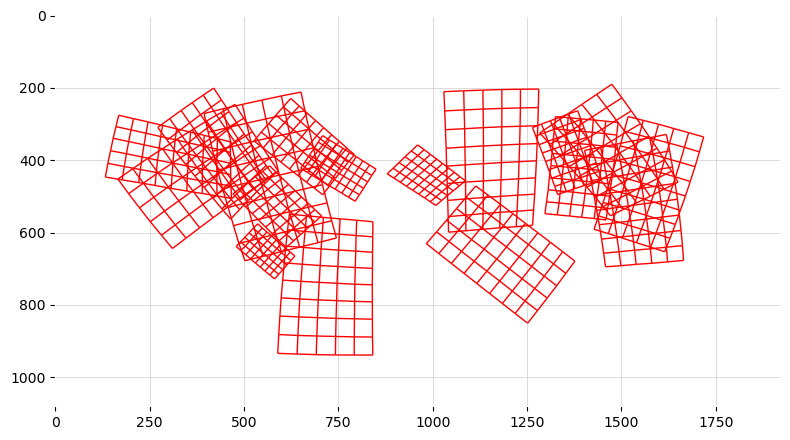

In [9]:
app.plot_corners(os.path.join(INTRINSIC_DATA_DIR, "points_{}.json".format(cam_name)))

# 4. Calibrate
If you are not satisfied with the calibration error, you can remove frames with inaccurate checkerboard points. A feature that shows you how much error each frame adds to the calibration is in the pipeline, but until then you have to determine those frames manually and then remove them

In [10]:
K, D, R, t, used_points, rms = app.calibrate_fisheye_intrinsics(
    points_fpath=os.path.join(INTRINSIC_DATA_DIR, "points_{}.json".format(cam_name)), 
    out_fpath=os.path.join(INTRINSIC_DATA_DIR, "camera_{}.json".format(cam_name))
)
print(f"\nRMS Error is {rms:.3f} pixels")

K:
 [[948.69473423   0.         962.07220566]
 [  0.         959.45382462 539.05614102]
 [  0.           0.           1.        ]] 
D:
 [[ 0.13704102]
 [-0.10826678]
 [ 0.11413751]
 [-0.06414592]]

RMS Error is 0.318 pixels


## 5. Plot undistorted points using newly-found intrinsic parameters

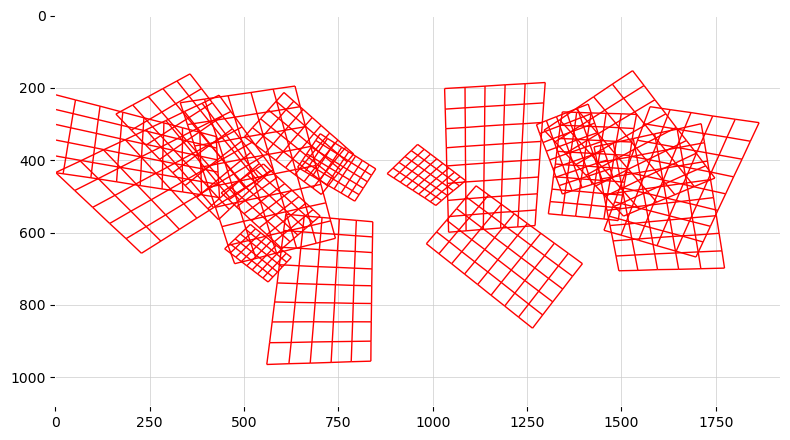

In [11]:
scene = app.plot_points_fisheye_undistort(
    points_fpath=os.path.join(INTRINSIC_DATA_DIR, "points_{}.json".format(cam_name)), 
    camera_fpath=os.path.join(INTRINSIC_DATA_DIR, "camera_{}.json".format(cam_name))
)

# Extrinsic calibration
## 0. Define params

In [3]:
# the path to the scene you wish to calibrate
DATA_DIR = os.path.join(DATA_ROOT_DIR, "11Oct2022S")
#DATA_DIR = os.path.join(DATA_ROOT_DIR, "sunday_amelia")
# Extrinsic checkerboard info
EXTRINSIC_BOARD_SHAPE = (9, 6)
EXTRINSIC_SQUARE_LEN = 0.031 # meters

### Automatically defined params
Do not modify

In [5]:
EXTRINSIC_DATA_DIR = os.path.join(DATA_DIR, "extrinsic_calib")
DUMMY_SCENE = os.path.abspath(os.path.join("..", "configs", "dummy_scene.json"))

# Camera settings
#VID_FPATHS = sorted(glob(os.path.join(EXTRINSIC_DATA_DIR, "videos", "cam[1-9].mp4"))) # paths to the calibration videos

#CAMS = [int(os.path.splitext(os.path.basename(cam))[0][-1]) for cam in VID_FPATHS] # must be sorted
#CAMS = ['RCL', 'RCR', 'SCL', 'SCR']
#CAMS = ['1', '2', '3', '4']
CAMS = ['1', '2']
#print("Cams:", CAMS)

# Intrinsic calibration
YEAR = 2022
INTRINSIC_DATA_DIR = os.path.join(DATA_ROOT_DIR, "intrinsic_calib", str(YEAR))

## 1. Extract frames from videos
You must first define the camera from which you wish to extract frames. ```camera``` must correspond to one of the numbers in ```CAMS```. Thereafter, use the GUI to save only those frames where the checkerboard squares are visible.

GUI usage:
- `.` - Next frame
- `,` - Previous frame
- `s` - Save current frame
- `q` - Quit

In [63]:
camera = 1  # Change as needed (in this example we have cameras 1,2,...
assert camera in CAMS

frames_fpath = os.path.join(EXTRINSIC_DATA_DIR, "frames", str(camera))
if not os.path.exists(frames_fpath):
    os.makedirs(frames_fpath)
print("The the output folder is", frames_fpath)

get_frames(VID_FPATHS[camera-1], frames_fpath)
# cv.waitKey(0); # Needed to close window properly
print('GREAT JOB!!')

AssertionError: 

### Optional: Convert frames to negatives
This is needed for the days that use the checkerboard with a black outline so that OpenCV can detect the checkerboard points correctly

In [ ]:
for cam in CAMS:
    frames_fpath = os.path.join(EXTRINSIC_DATA_DIR, "frames", str(cam))
    neg_frames_dir = os.path.join(EXTRINSIC_DATA_DIR, "neg_frames", str(cam))
    if not os.path.exists(neg_frames_dir):
        os.makedirs(neg_frames_dir)
    print("The the output folder is", neg_frames_dir)
    
    for fname in os.listdir(frames_fpath):
        fname = fname.lower()
        if fname.endswith(".jpg") or fname.endswith(".png"):
            img = cv.imread(os.path.join(frames_fpath, fname))
            img_neg = (255 - img)
            cv.imwrite(os.path.join(neg_frames_dir, fname), img_neg)

## 2. Find calibration board corners
Note: This takes a while!

You must first define OpenCV's window size. You may need to rerun this cell with various window sizes until you are happy with the accuracy of the results.
If the checkerboard with the black outline is used in the calibration vids, change ```'frames'``` to ```'neg_frames'```

Finding calibration board corners for images in ..\data\11Oct2022S\extrinsic_calib\frames\1
Found corners for file 0: ..\data\11Oct2022S\extrinsic_calib\frames\1\4144.jpg
Found corners for file 1: ..\data\11Oct2022S\extrinsic_calib\frames\1\4178.jpg
Found corners for file 2: ..\data\11Oct2022S\extrinsic_calib\frames\1\4277.jpg
Found corners for file 3: ..\data\11Oct2022S\extrinsic_calib\frames\1\4904.jpg
Found corners for file 4: ..\data\11Oct2022S\extrinsic_calib\frames\1\5366.jpg
Found corners for file 5: ..\data\11Oct2022S\extrinsic_calib\frames\1\5663.jpg
Found corners for file 6: ..\data\11Oct2022S\extrinsic_calib\frames\1\6323.jpg
Found corners for file 7: ..\data\11Oct2022S\extrinsic_calib\frames\1\6455.jpg
Saving points to ..\data\11Oct2022S\extrinsic_calib\points\points_cam1.json
Finding calibration board corners for images in ..\data\11Oct2022S\extrinsic_calib\frames\2
Found corners for file 0: ..\data\11Oct2022S\extrinsic_calib\frames\2\4144.jpg
Found corners for file 1: ..\

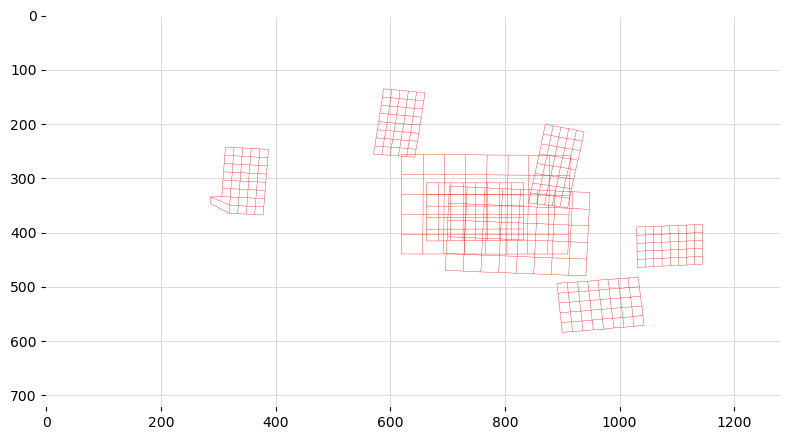

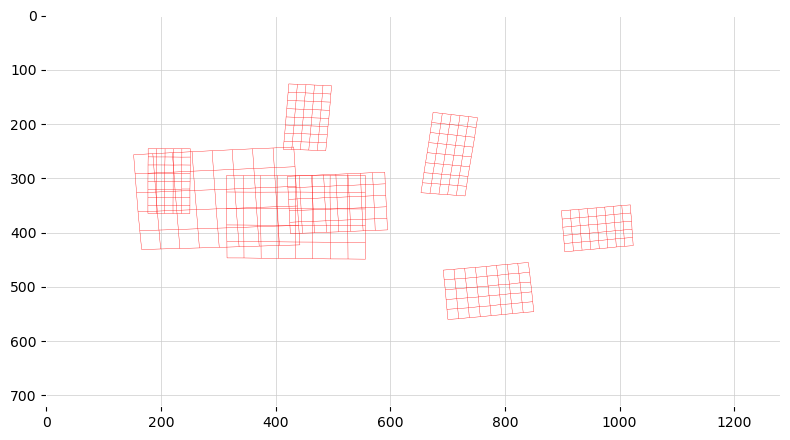

In [6]:
window_size = 10
CAMS = ['1', '2']
# set directories
points_dir = os.path.join(EXTRINSIC_DATA_DIR, 'points')
if not os.path.exists(points_dir):
    os.makedirs(points_dir)
data_dirs = [[
    os.path.join(EXTRINSIC_DATA_DIR, "frames",cam),
    os.path.join(points_dir, f"points_cam{cam}.json")
] for cam in CAMS]

# Find calibration board corners in images and save points
for [img_dir, out_fpath] in data_dirs:
    # 'window_size' sets the size of the calibration board corner detector window size
    app.extract_corners_from_images(
        img_dir, 
        out_fpath,
        EXTRINSIC_BOARD_SHAPE,
        EXTRINSIC_SQUARE_LEN, 
        window_size=window_size, 
        remove_unused_images=False
    )

app.plot_corners(os.path.join(points_dir, "points_cam1.json"))
app.plot_corners(os.path.join(points_dir, "points_cam2.json"))
#app.plot_corners(os.path.join(points_dir, "points_cam3.json"))
#app.plot_corners(os.path.join(points_dir, "points_cam4.json"))

### Correct points that were detected in the reversed order
Sometimes OpenCV detects a frame's checkerboard points in the reverse direction relative to other frames. Use this code to correct those points.

For each cam, you must manually insert the frame number that has reversed points. Eg. if img00012.jpg and img00100.jpg from cam3 has reversed points then ```frames = [[],
[],
[12, 100],
[],
[],
[]]```
(assuming there are 6 cams in this example)

In [83]:
points_fpaths = sorted(glob(os.path.join(EXTRINSIC_DATA_DIR, "points", "points_cam[1-2].json")))
print(points_fpaths)

# list of frames where checkerboard points were detected in the wrong orientation
frames = [[],
         [],
         [],
         []       
         ]
assert len(frames) == len(points_fpaths)

for i in range(len(frames)):
    if frames[i]:
        points, fnames, board_shape, board_edge_len, cam_res = load_points(points_fpaths[i])
        for f in frames[i]:
            img_name = f"img{f:05}.jpg"
            index = fnames.index(img_name)
            img_pts = points[index]
            points[index] = np.flip(img_pts, (0, 1))
        save_points(points_fpaths[i], points, fnames, board_shape, board_edge_len, cam_res)

['..\\data\\sportCentreNaoya_Ex1\\extrinsic_calib\\points\\points_cam1.json', '..\\data\\sportCentreNaoya_Ex1\\extrinsic_calib\\points\\points_cam2.json', '..\\data\\sportCentreNaoya_Ex1\\extrinsic_calib\\points\\points_cam3.json', '..\\data\\sportCentreNaoya_Ex1\\extrinsic_calib\\points\\points_cam4.json']


## 3. Calibrate pairwise extrinsics
If one or more cam pairs do not have common image points, you need to use Argus Clicker to define manual points. Thereafter you must rerun the cell below to finalise the extrinsics. If the manual points minimization did not yield satisfactory extrinsic results, you have to adjust the ```redescending_loss``` params in ```calib.adjust_extrinsics_manual_points``` by trial and error (for now) until the results are satisfactory

In [7]:
camera_fpaths = [os.path.join(INTRINSIC_DATA_DIR, "camera_1.json"), 
                    os.path.join(INTRINSIC_DATA_DIR, "camera_2.json")
                ]
#camera_fpathsS = [os.path.join(INTRINSIC_DATA_DIR, "camera_3.json"), 
#                    os.path.join(INTRINSIC_DATA_DIR, "camera_4.json")
 #               ]

points_fpaths = sorted(glob(os.path.join(EXTRINSIC_DATA_DIR, 'points','points_cam[1-2].json')))
#points_fpathsS = sorted(glob(os.path.join(EXTRINSIC_DATA_DIR, 'points','points_cam[3-4].json')))

scene_fpath = os.path.join(EXTRINSIC_DATA_DIR, f"{len(points_fpaths)}_cam_scene.json")
#scene_fpathS = os.path.join(EXTRINSIC_DATA_DIR, f"{len(points_fpaths)}_cam_scene_static.json")

app.calibrate_fisheye_extrinsics_pairwise(
    camera_fpaths, points_fpaths, 
    out_fpath=scene_fpath)# cams=CAMS,
    #dummy_scene_fpath=DUMMY_SCENE)

#app.calibrate_fisheye_extrinsics_pairwise(
#    camera_fpathsS, points_fpathsS, 
#    out_fpath=scene_fpathS,# cams=CAMS,
#    dummy_scene_fpath=DUMMY_SCENE)


R Opencv
[[ 0.9991608   0.03909149  0.01222925]
 [-0.03912079  0.99923214  0.00216618]
 [-0.01213518 -0.00264278  0.99992287]]
[[-0.48814285]
 [ 0.00379645]
 [ 0.01766493]]
T Opencv
R_arr
[array([[ 1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]], dtype=float32), array([[ 0.9991608 ,  0.01222925, -0.03909149],
       [-0.03912079,  0.00216618, -0.99923214],
       [-0.01213518,  0.99992287,  0.00264278]])]
T_arr
[array([[0.],
       [0.],
       [0.]], dtype=float32), array([[-0.48814285],
       [ 0.00379645],
       [ 0.01766493]])]


## 4. Run calibration SBA
Note: Also takes a while!

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3580e+02                                    9.36e+04    
       1              4         3.3277e+02      3.03e+00       3.61e-03       5.86e+04    
       2              7         3.3226e+02      5.14e-01       1.12e-03       5.86e+04    
       3              8         3.3135e+02      9.04e-01       2.06e-03       5.73e+04    
       4              9         3.3024e+02      1.11e+00       3.55e-03       5.84e+04    
       5             10         3.2847e+02      1.77e+00       3.19e-03       5.95e+04    
       6             12         3.2724e+02      1.24e+00       1.56e-03       6.01e+04    
       7             13         3.2569e+02      1.54e+00       3.17e-03       6.23e+04    
       8             14         3.2311e+02      2.59e+00       3.10e-03       6.50e+04    
       9             15         3.1749e+02      5.61e+00       6.86e-03       7.02e+04    

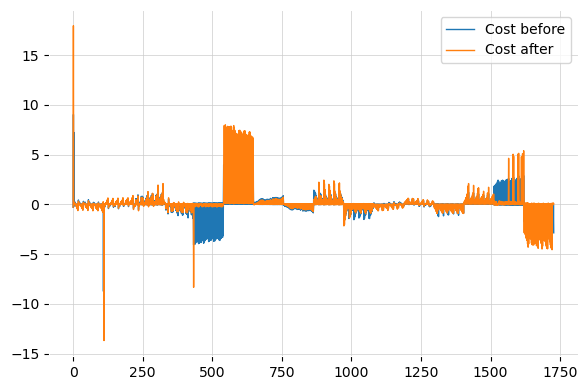

In [8]:
scene_sba_fpathR = scene_fpath.replace('.json','_sba.json')
#scene_sba_fpathS = scene_fpathS.replace('.json','_sba.json')

resR = app.sba_board_points_fisheye(
    scene_fpath, points_fpaths, out_fpath=scene_sba_fpathR
    #, manual_points_fpath=manual_points_fpath#, manual_points_only=True,
    # camera_indices=None
)
#resS = app.sba_board_points_fisheye(
#    scene_fpathS, points_fpathsS, out_fpath=scene_sba_fpathS
#    #, manual_points_fpath=manual_points_fpath#, manual_points_only=True,
#    # camera_indices=None
#)

plt.plot(resR['before'], label="Cost before")
plt.plot(resR['after'], label="Cost after")
plt.legend()
plt.show()

#plt.plot(resS['before'], label="Cost before")
#plt.plot(resS['after'], label="Cost after")
#plt.legend()
#plt.show()

## 5. Visualize
### Plot checkerboard points

In [9]:
#app.plot_scene(DATA_DIR, dark_mode=True)
# Optionally, specify a certain scene file to view
#app.plot_scene(EXTRINSIC_DATA_DIR, scene_fname='2_cam_scene_rotating_sba.json', dark_mode=True)
app.plot_scene(os.path.join(EXTRINSIC_DATA_DIR, '2_cam_scene_rotating_sba.json'))

### Plot manually defined points

In [ ]:
app.plot_scene(DATA_DIR, manual_points_only=True, dark_mode=True)